<a href="https://colab.research.google.com/github/njadux/Transformer-Question-and-Answering-System/blob/main/Question_and_Answering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Load the Pre-Trained BERT Model

In [ ]:
import torch
from transformers import BertForQuestionAnswering

In [ ]:
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

2. Define the Question and Context

In [ ]:
question = 'How many parameters does BERT-large have?'
answer_text= 'BERT-large is really big... it has 24-layers and an embedding size of 1,024, for a total of 340M parameters!'

3. Tokenization

In [ ]:
input_ids = tokenizer.encode(question, answer_text)
print('The input has a total of {:} tokens.'.format(len(input_ids)))

The input has a total of 46 tokens.


In [ ]:
tokens = tokenizer.convert_ids_to_tokens(input_ids)

for token, id in zip(tokens, input_ids):
  if id == tokenizer.sep_token_id:
    print('')
  print('{:<12}{:>6,}'.format(token, id))

  if id == tokenizer.sep_token_id:
    print('')

[CLS]          101
how          2,129
many         2,116
parameters  11,709
does         2,515
bert        14,324
-            1,011
large        2,312
have         2,031
?            1,029

[SEP]          102

bert        14,324
-            1,011
large        2,312
is           2,003
really       2,428
big          2,502
.            1,012
.            1,012
.            1,012
it           2,009
has          2,038
24           2,484
-            1,011
layers       9,014
and          1,998
an           2,019
em           7,861
##bed        8,270
##ding       4,667
size         2,946
of           1,997
1            1,015
,            1,010
02           6,185
##4          2,549
,            1,010
for          2,005
a            1,037
total        2,561
of           1,997
340         16,029
##m          2,213
parameters  11,709
!              999

[SEP]          102



4. Segment Encoding

In [ ]:
sep_index = input_ids.index(tokenizer.sep_token_id)
num_seg_a = sep_index + 1
num_seg_b = len(input_ids) - num_seg_a

segment_ids = [0]*num_seg_a + [1]*num_seg_b
assert len(segment_ids) == len(input_ids)

In [ ]:
# FIX: Convert inputs to Tensors and add a batch dimension (unsqueeze(0) or [None, ...])
input_ids_tensor = torch.tensor([input_ids])
segment_ids_tensor = torch.tensor([segment_ids])

5. Run the Model (Inference)

In [ ]:
outputs = model(input_ids_tensor, token_type_ids=segment_ids_tensor)
print("\nModel output type:", type(outputs))


Model output type: <class 'transformers.modeling_outputs.QuestionAnsweringModelOutput'>


In [ ]:
# Call the model with the correctly formatted Tensors
start_scores, end_scores = model(input_ids_tensor, token_type_ids=segment_ids_tensor)

In [ ]:
print(f"Type of start_scores: {type(start_scores)}")

Type of start_scores: <class 'str'>


In [ ]:
start_scores = outputs.start_logits
end_scores = outputs.end_logits

answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

6. Extract and Print the Answer

In [ ]:
# Fix for the join operation (argmax returns a single-item tensor, so call .item()):
answer = ' '.join(tokens[answer_start.item():answer_end.item() + 1])
print('Answer: "' + answer + '"')

Answer: "340 ##m"


In [ ]:
# Access the tensor outputs from the model's output tuple
print(type(start_scores))

print(type(end_scores))



<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [ ]:
answer = tokens[answer_start]

for i in range(answer_start + 1, answer_end + 1):
    if tokens[i][0:2] == '##':
        answer += tokens[i][2:]
    else:
        answer += ' ' + tokens[i]
print('Answer: "' + answer + '"')

Answer: "340m"


In [ ]:
# visualize scoring
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
plt.rcParams["figure.figsize"] = (16,8)

In [ ]:
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

In [ ]:
token_labels = []
for (i, token) in enumerate(tokens):
  token_labels.append('{:} - {:>2}'.format(token, i))

/tmp/ipython-input-1571492391.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x = token_labels, y = s_scores, ci=None)
/tmp/ipython-input-1571492391.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')


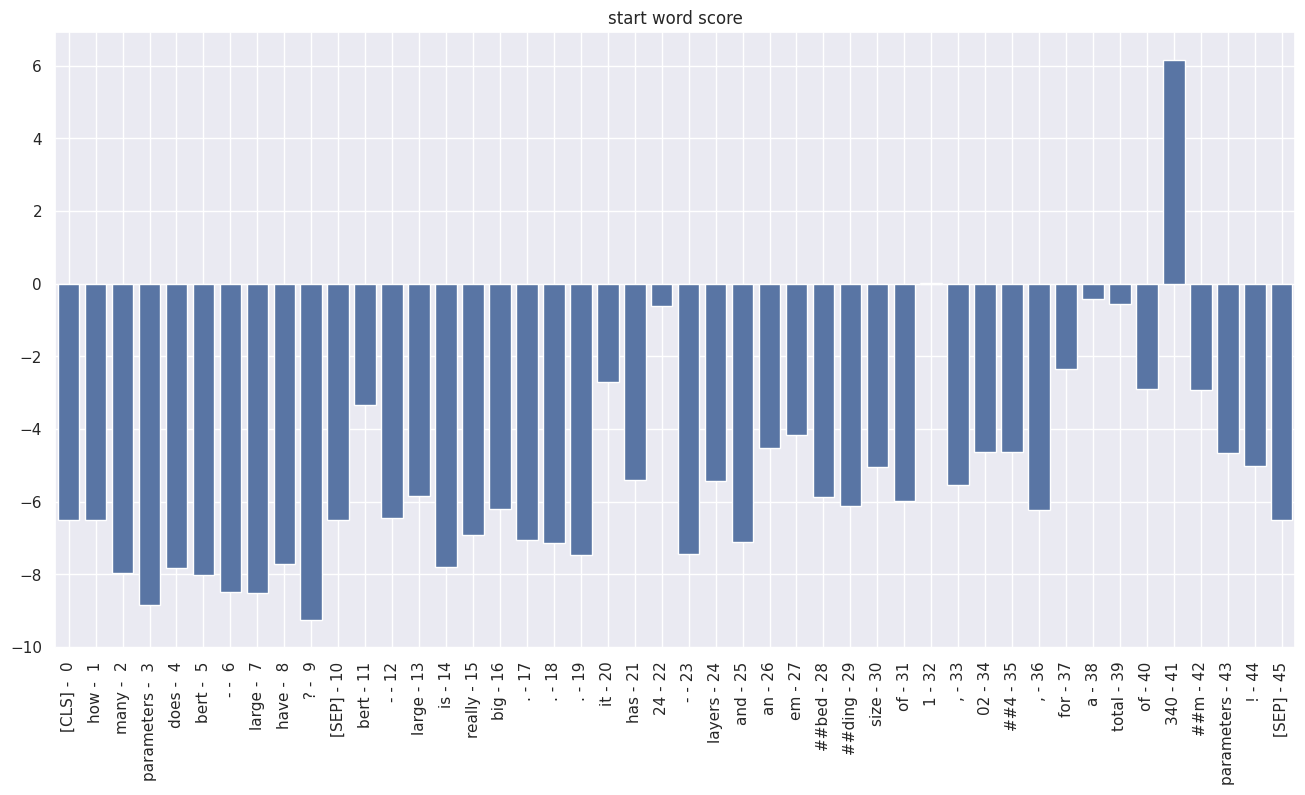

In [ ]:
ax = sns.barplot(x = token_labels, y = s_scores, ci=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')

ax.grid(True)
plt.title('start word score')
plt.show()

/tmp/ipython-input-4230174678.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


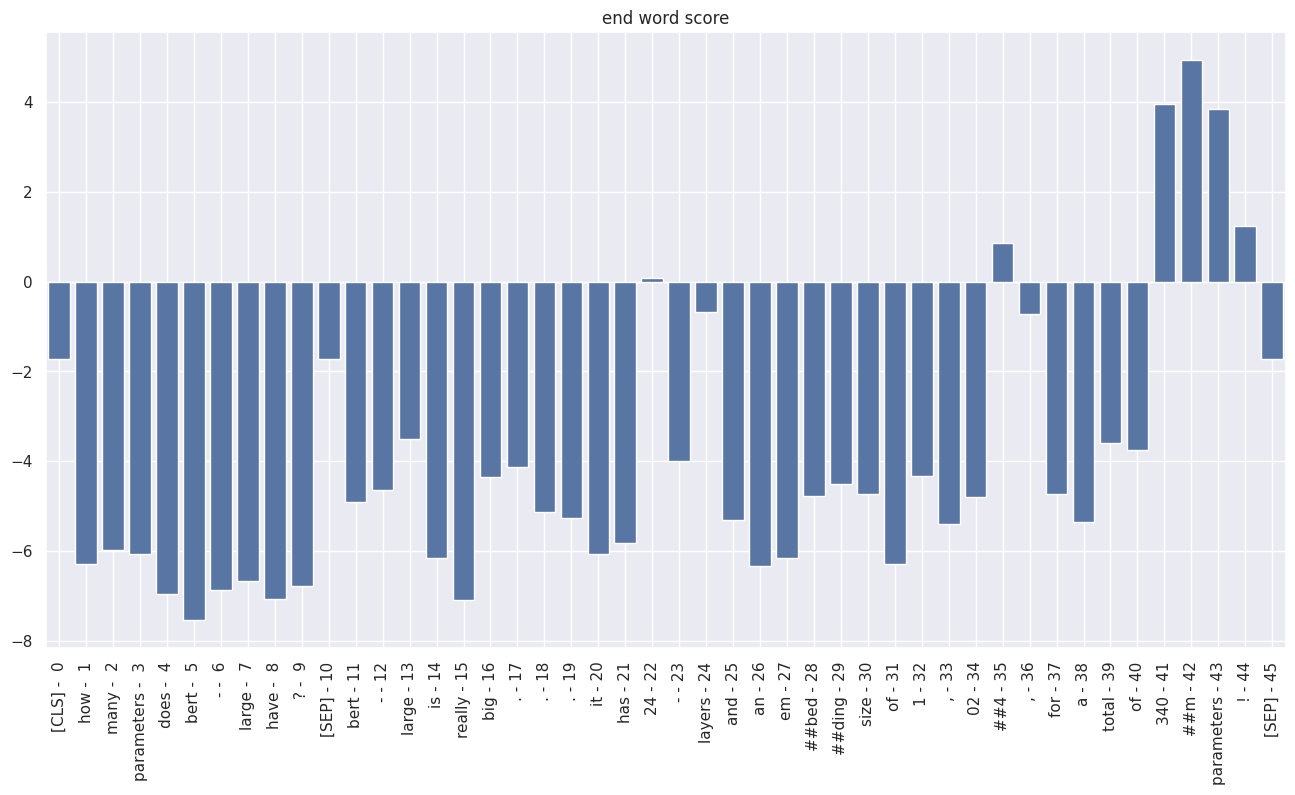

In [ ]:
ax = sns.barplot(x = token_labels, y = e_scores)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

ax.grid(True)
plt.title('end word score')
plt.show()

8. Wrap Everything in a Function

In [ ]:
def answer_question(question, answer_text):
  input_ids = tokenizer.encode(question, answer_text)
  print('Query has {:,} tokens.\n'.format(len(input_ids)))
  sep_index = input_ids.index(tokenizer.sep_token_id)
  num_seg_a = sep_index + 1
  num_seg_b = len(input_ids) - num_seg_a


  segment_ids = [0]*num_seg_a + [1]*num_seg_b

  assert len(segment_ids) == len(input_ids)

  # Call the model and access the logits from the output object
  outputs = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]))
  start_scores = outputs.start_logits
  end_scores = outputs.end_logits

  answer_start = torch.argmax(start_scores)
  answer_end = torch.argmax(end_scores)

  tokens = tokenizer.convert_ids_to_tokens(input_ids)

  answer = tokens[answer_start]

  for i in range(answer_start + 1, answer_end + 1):
    if tokens[i][0:2] == '##':
      answer += tokens[i][2:]
    else:
      answer += ' ' + tokens[i]
  print('Answer: "' + answer + '"')

In [ ]:
import textwrap

wrapper = textwrap.TextWrapper(width=80)
bert_abstract = 'We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers.'

print(wrapper.fill(bert_abstract))

We introduce a new language representation model called BERT, which stands for
Bidirectional Encoder Representations from Transformers.


In [ ]:
question = "what does 'B' in BERT stands for?"
answer_question(question, bert_abstract)

Query has 37 tokens.

Answer: "bidirectional encoder representations from transformers"


Evaluation (Exact Match + F1)

In [ ]:
import re
import string
import numpy as np

# --- TEXT NORMALIZATION (like SQuAD official evaluation) ---
def normalize_text(s):
    """Lowercase, remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)
    def remove_punc(text):
        return ''.join(ch for ch in text if ch not in string.punctuation)
    def white_space_fix(text):
        return ' '.join(text.split())
    return white_space_fix(remove_articles(remove_punc(s.lower())))

# --- EXACT MATCH ---
def exact_match(prediction, ground_truth):
    return int(normalize_text(prediction) == normalize_text(ground_truth))

# --- F1 SCORE ---
def f1_score(prediction, ground_truth):
    prediction_tokens = normalize_text(prediction).split()
    ground_truth_tokens = normalize_text(ground_truth).split()
    common = set(prediction_tokens) & set(ground_truth_tokens)
    num_same = len(common)
    if len(prediction_tokens) == 0 or len(ground_truth_tokens) == 0:
        return int(prediction_tokens == ground_truth_tokens)
    if num_same == 0:
        return 0
    precision = num_same / len(prediction_tokens)
    recall = num_same / len(ground_truth_tokens)
    return (2 * precision * recall) / (precision + recall)

# --- EVALUATION LOOP ---
def evaluate_qa_model(samples):
    em_scores = []
    f1_scores = []
    for i, sample in enumerate(samples):
        question = sample["question"]
        context = sample["context"]
        true_answer = sample["answer"]
        print(f"\n[{i+1}] Question: {question}")

        # Use your existing QA function
        input_ids = tokenizer.encode(question, context)
        sep_index = input_ids.index(tokenizer.sep_token_id)
        num_seg_a = sep_index + 1
        num_seg_b = len(input_ids) - num_seg_a
        segment_ids = [0]*num_seg_a + [1]*num_seg_b

        outputs = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]))
        start_scores = outputs.start_logits
        end_scores = outputs.end_logits

        tokens = tokenizer.convert_ids_to_tokens(input_ids)
        answer_start = torch.argmax(start_scores)
        answer_end = torch.argmax(end_scores)

        # Build the predicted answer
        pred = tokens[answer_start]
        for j in range(answer_start + 1, answer_end + 1):
            if tokens[j][0:2] == '##':
                pred += tokens[j][2:]
            else:
                pred += ' ' + tokens[j]

        print(f"Predicted: {pred}")
        print(f"True: {true_answer}")

        em = exact_match(pred, true_answer)
        f1 = f1_score(pred, true_answer)
        print(f"EM: {em:.2f} | F1: {f1:.2f}")

        em_scores.append(em)
        f1_scores.append(f1)

    print("\n Overall Evaluation:")
    print(f"Exact Match (EM): {np.mean(em_scores):.3f}")
    print(f"F1 Score: {np.mean(f1_scores):.3f}")

Trying it on a Mini Dataset

In [ ]:
samples = [
    {
        "question": "How many parameters does BERT-large have?",
        "context": "BERT-large is really big... it has 24-layers and an embedding size of 1,024, for a total of 340M parameters!",
        "answer": "340M parameters"
    },
    {
        "question": "What does the 'B' in BERT stand for?",
        "context": "We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers.",
        "answer": "Bidirectional"
    }
]

evaluate_qa_model(samples)


[1] Question: How many parameters does BERT-large have?
Predicted: 340m
True: 340M parameters
EM: 0.00 | F1: 0.67

[2] Question: What does the 'B' in BERT stand for?
Predicted: bidirectional encoder representations from transformers
True: Bidirectional
EM: 0.00 | F1: 0.33

 Overall Evaluation:
Exact Match (EM): 0.000
F1 Score: 0.500


In [ ]:
!pip install streamlit transformers torch matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 133.6 MB/s eta 0:00:00


In [ ]:
!pip install streamlit pyngrok --quiet


Create the Streamlit App File

In [ ]:
%%writefile app.py
import streamlit as st
import torch
from transformers import BertForQuestionAnswering, BertTokenizer
import numpy as np
import re
import string
import matplotlib.pyplot as plt

@st.cache_resource
def load_model():
    model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
    tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
    return model, tokenizer

model, tokenizer = load_model()

def normalize_text(s):
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)
    def remove_punc(text):
        return ''.join(ch for ch in text if ch not in string.punctuation)
    def white_space_fix(text):
        return ' '.join(text.split())
    return white_space_fix(remove_articles(remove_punc(s.lower())))

def exact_match(pred, true):
    return int(normalize_text(pred) == normalize_text(true))

def f1_score(pred, true):
    pred_tokens = normalize_text(pred).split()
    true_tokens = normalize_text(true).split()
    common = set(pred_tokens) & set(true_tokens)
    num_same = len(common)
    if len(pred_tokens) == 0 or len(true_tokens) == 0:
        return int(pred_tokens == true_tokens)
    if num_same == 0:
        return 0
    precision = num_same / len(pred_tokens)
    recall = num_same / len(true_tokens)
    return (2 * precision * recall) / (precision + recall)

def get_answer(question, context):
    input_ids = tokenizer.encode(question, context)
    sep_index = input_ids.index(tokenizer.sep_token_id)
    num_seg_a = sep_index + 1
    num_seg_b = len(input_ids) - num_seg_a
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    outputs = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]))
    start_scores = outputs.start_logits
    end_scores = outputs.end_logits

    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    start_idx = torch.argmax(start_scores)
    end_idx = torch.argmax(end_scores)

    answer = tokens[start_idx]
    for i in range(start_idx + 1, end_idx + 1):
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        else:
            answer += ' ' + tokens[i]
    return answer, start_scores.detach().numpy().flatten(), end_scores.detach().numpy().flatten(), tokens

st.title("🧠 BERT Question Answering System")
st.write("Ask a question about a passage using BERT-large fine-tuned on SQuAD.")

context = st.text_area("📝 Context Passage", height=200, placeholder="Paste your paragraph here...")
question = st.text_input("❓ Your Question", placeholder="Ask something based on the passage...")
true_answer = st.text_input("✅ (Optional) True Answer (for evaluation)")

if st.button("Get Answer"):
    if context.strip() == "" or question.strip() == "":
        st.warning("Please enter both a context and a question!")
    else:
        with st.spinner("Thinking... 🤔"):
            pred, start_scores, end_scores, tokens = get_answer(question, context)
        st.subheader("💡 Predicted Answer:")
        st.success(pred)

        if true_answer.strip() != "":
            em = exact_match(pred, true_answer)
            f1 = f1_score(pred, true_answer)
            st.write(f"**Exact Match (EM):** {em:.2f}")
            st.write(f"**F1 Score:** {f1:.2f}")

        st.write("### 🔍 Token Confidence Scores")
        fig, ax = plt.subplots(2, 1, figsize=(16, 6))
        token_labels = [f"{t}-{i}" for i, t in enumerate(tokens)]
        ax[0].bar(range(len(tokens)), start_scores)
        ax[0].set_title("Start Token Scores")
        ax[0].set_xticks(range(len(tokens)))
        ax[0].set_xticklabels(token_labels, rotation=90, fontsize=8)
        ax[1].bar(range(len(tokens)), end_scores)
        ax[1].set_title("End Token Scores")
        ax[1].set_xticks(range(len(tokens)))
        ax[1].set_xticklabels(token_labels, rotation=90, fontsize=8)
        st.pyplot(fig)


Writing app.py


Run Streamlit via ngrok

In [ ]:
!ngrok config add-authtoken '2y61OmwmzjGdfMSJzrAGqfmbgSK_2qTx1ZddRWACpqf4ooLSz'

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok

# Kill any old tunnels
!pkill streamlit || echo "No running Streamlit app"

# Start a new public tunnel
public_url = ngrok.connect(8501)
print(f"🌍 Streamlit app link: {public_url}")

# Run the app silently
!streamlit run app.py --server.port 8501 > /dev/null 2>&1 &

No running Streamlit app
🌍 Streamlit app link: NgrokTunnel: "https://095bccbceb17.ngrok-free.app" -> "http://localhost:8501"


use the SQuAD dataset,

evaluate different models (not just one),

handle dataset splits properly, and

compare performance.

In [ ]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("squad")

# Check structure
print(dataset)
print(dataset['train'][0])

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

plain_text/validation-00000-of-00001.par(…):   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})
{'id': '5733be284776f41900661182', 'title': 'University_of_Notre_Dame', 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome

Use Pretrained Models Trained on Dataset

In [ ]:
import torch
from transformers import AutoModelForQuestionAnswering, AutoTokenizer
from tqdm import tqdm
import re, string

def normalize_text(s):
    def remove_articles(text): return re.sub(r'\b(a|an|the)\b', ' ', text)
    def remove_punc(text): return ''.join(ch for ch in text if ch not in string.punctuation)
    def white_space_fix(text): return ' '.join(text.split())
    return white_space_fix(remove_articles(remove_punc(s.lower())))

def f1_score(pred, true):
    pred_tokens = normalize_text(pred).split()
    true_tokens = normalize_text(true).split()
    common = set(pred_tokens) & set(true_tokens)
    num_same = len(common)
    if len(pred_tokens) == 0 or len(true_tokens) == 0: return int(pred_tokens == true_tokens)
    if num_same == 0: return 0
    precision = num_same / len(pred_tokens)
    recall = num_same / len(true_tokens)
    return (2 * precision * recall) / (precision + recall)

def exact_match(pred, true):
    return int(normalize_text(pred) == normalize_text(true))

In [ ]:
models = [
    "bert-large-uncased-whole-word-masking-finetuned-squad",
    "distilbert-base-uncased-distilled-squad",
    "deepset/roberta-base-squad2"
]

results = []

for model_name in models:
    print(f"\n Evaluating {model_name} ...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForQuestionAnswering.from_pretrained(model_name)

    f1_total, em_total = 0, 0
    num_samples = 20  # test size for speed

    for i in tqdm(range(num_samples)):
        q = dataset['validation'][i]['question']
        c = dataset['validation'][i]['context']
        true_ans = dataset['validation'][i]['answers']['text'][0]

        inputs = tokenizer.encode_plus(q, c, return_tensors="pt")
        outputs = model(**inputs)

        start_idx = torch.argmax(outputs.start_logits)
        end_idx = torch.argmax(outputs.end_logits)
        all_tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
        answer = tokenizer.convert_tokens_to_string(all_tokens[start_idx:end_idx+1])

        f1_total += f1_score(answer, true_ans)
        em_total += exact_match(answer, true_ans)

    avg_f1 = f1_total / num_samples
    avg_em = em_total / num_samples
    results.append((model_name, avg_em, avg_f1))
    print(f" {model_name} — EM: {avg_em:.3f}, F1: {avg_f1:.3f}")


 Evaluating bert-large-uncased-whole-word-masking-finetuned-squad ...


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 20/20 [01:09<00:00,  3.48s/it]


 bert-large-uncased-whole-word-masking-finetuned-squad — EM: 0.650, F1: 0.790

 Evaluating distilbert-base-uncased-distilled-squad ...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/451 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

100%|██████████| 20/20 [00:06<00:00,  3.19it/s]

 distilbert-base-uncased-distilled-squad — EM: 0.600, F1: 0.640

 Evaluating deepset/roberta-base-squad2 ...


tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

100%|██████████| 20/20 [00:11<00:00,  1.77it/s]

 deepset/roberta-base-squad2 — EM: 0.900, F1: 0.921


In [ ]:
import pandas as pd
df = pd.DataFrame(results, columns=["Model", "Exact Match", "F1 Score"])
df

,Model,Exact Match,F1 Score
0,bert-large-uncased-whole-word-masking-finetune...,0.65,0.790000
1,distilbert-base-uncased-distilled-squad,0.60,0.640000
2,deepset/roberta-base-squad2,0.90,0.921429


Transfer learning on top of a fine-tuned model, i.e. “domain re-finetuning.”


In [ ]:
small_train = dataset["train"].select(range(1000))
small_val = dataset["validation"].select(range(200))

In [ ]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer

model_name = "bert-large-uncased-whole-word-masking-finetuned-squad"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Preprocess the Data

In [ ]:
max_length = 384
stride = 128

def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        stride=stride,
        truncation="only_second",
        padding="max_length",
        return_offsets_mapping=True,
    )
    start_positions = []
    end_positions = []
    for i, offset in enumerate(inputs["offset_mapping"]):
        answer = examples["answers"][i]
        start_char = answer["answer_start"][0]
        end_char = start_char + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find start and end token indices
        context_index = 1
        token_start_index = 0
        while sequence_ids[token_start_index] != context_index:
            token_start_index += 1
        token_end_index = len(inputs["input_ids"][i]) - 1
        while sequence_ids[token_end_index] != context_index:
            token_end_index -= 1

        if not (offset[token_start_index][0] <= start_char and offset[token_end_index][1] >= end_char):
            start_positions.append(0)
            end_positions.append(0)
        else:
            while token_start_index < len(offset) and offset[token_start_index][0] <= start_char:
                token_start_index += 1
            start_positions.append(token_start_index - 1)
            while offset[token_end_index][1] >= end_char:
                token_end_index -= 1
            end_positions.append(token_end_index + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

tokenized_train = small_train.map(preprocess_function, batched=True, remove_columns=dataset["train"].column_names)
tokenized_val = small_val.map(preprocess_function, batched=True, remove_columns=dataset["validation"].column_names)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Training Setup

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch", # Corrected parameter name
    learning_rate=3e-5,
    num_train_epochs=1,  # keep it low for demo
    weight_decay=0.01,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    save_total_limit=1,
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: njadux (njadux-google-wtm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,No log,1.085955


TrainOutput(global_step=250, training_loss=0.5010932312011719, metrics={'train_runtime': 366.3308, 'train_samples_per_second': 2.73, 'train_steps_per_second': 0.682, 'total_flos': 696530244096000.0, 'train_loss': 0.5010932312011719, 'epoch': 1.0})

In [ ]:
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 1.0859553813934326, 'eval_runtime': 14.3183, 'eval_samples_per_second': 13.968, 'eval_steps_per_second': 3.492, 'epoch': 1.0}


Save New Model

In [ ]:
trainer.save_model("finetuned-bert-squad-custom")
tokenizer.save_pretrained("finetuned-bert-squad-custom")

('finetuned-bert-squad-custom/tokenizer_config.json',
 'finetuned-bert-squad-custom/special_tokens_map.json',
 'finetuned-bert-squad-custom/vocab.txt',
 'finetuned-bert-squad-custom/added_tokens.json',
 'finetuned-bert-squad-custom/tokenizer.json')

can plug it back into Streamlit app:

In [ ]:
model = BertForQuestionAnswering.from_pretrained("finetuned-bert-squad-custom")
tokenizer = BertTokenizer.from_pretrained("finetuned-bert-squad-custom")